In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

P_high = np.sqrt(df['HUFL']**2 + df['HULL']**2)
P_mid  = np.sqrt(df['MUFL']**2 + df['MULL']**2)
P_low  = np.sqrt(df['LUFL']**2 + df['LULL']**2)

X_elec = StandardScaler().fit_transform(
    np.c_[P_high, P_mid, P_low]
)

X_therm = StandardScaler().fit_transform(df[['OT']])

X = np.hstack([X_elec, X_therm])

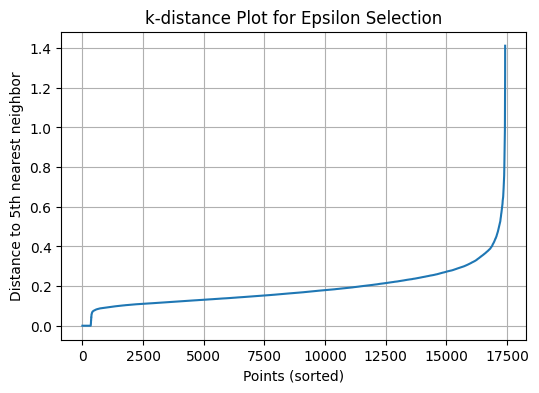

In [2]:
# We are trying to find the ideal value of epsilon in this block of code.

k = 5
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(X)

distances, _ = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Points (sorted)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("k-distance Plot for Epsilon Selection")
plt.grid()
plt.show()

The elbow in the k-distance plot provides a heuristic for selecting ε.

In [3]:
# Calculating the ideal value of epsilon

x = np.arange(len(k_distances))
y = k_distances

# Line between first and last point
point1 = np.array([x[0], y[0]])
point2 = np.array([x[-1], y[-1]])

# Compute perpendicular distances
distances_to_line = np.abs(
    np.cross(point2 - point1, point1 - np.vstack((x, y)).T)
) / np.linalg.norm(point2 - point1)

# Elbow index
elbow_index = np.argmax(distances_to_line)
eps_optimal = k_distances[elbow_index]

print(eps_optimal)

0.33062032183972057


In [4]:
reg = Ridge(alpha=1.0)
reg.fit(X, df['OT'])

# Predict expected oil temperature
df['OT_pred'] = reg.predict(X)

df['residual'] = df['OT'] - df['OT_pred']

res_threshold = df['residual'].quantile(0.95)  # top 5% positive deviations
res_anomaly = df['residual'] >= res_threshold

In [6]:
clustering = DBSCAN(eps=eps_optimal, min_samples=5, metric='euclidean')
clustering.fit(X)
df['cluster'] = clustering.labels_

ot_threshold = df['OT'].quantile(0.85)   # top 15% temperatures

# Physics-aware anomaly mask (high-OT only)
anomaly_mask = (df['cluster'] == -1) & (df['OT'] >= ot_threshold)

# noise statistics
dbscan_noise_count = (df['cluster'] == -1).sum()
dbscan_noise_ratio = np.mean(df['cluster'] == -1)

print(f"DBSCAN noise points: {dbscan_noise_count}")
print(f"DBSCAN noise ratio: {dbscan_noise_ratio:.4f}")

n_anomalies = anomaly_mask.sum()
anomaly_ratio = np.mean(anomaly_mask)

print(f"High-OT anomaly candidates: {n_anomalies}")
print(f"High-OT anomaly ratio: {anomaly_ratio:.4f}")

final_anomaly = anomaly_mask | res_anomaly

DBSCAN noise points: 607
DBSCAN noise ratio: 0.0348
High-OT anomaly candidates: 249
High-OT anomaly ratio: 0.0143


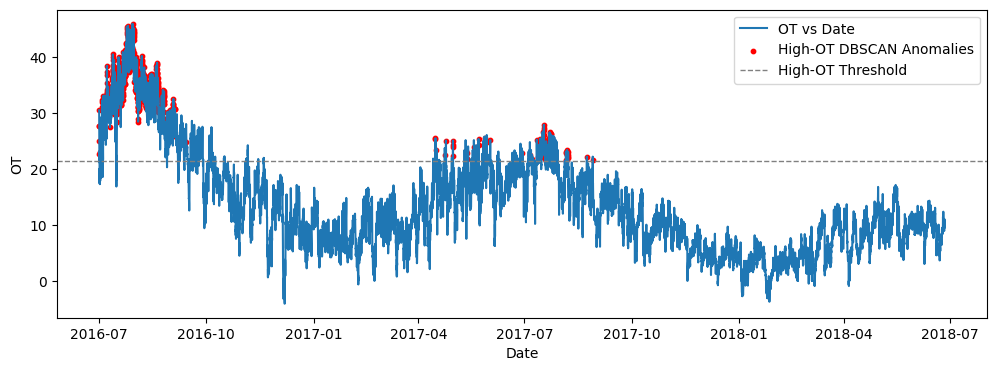

In [7]:
# Plotting the outliers
plt.figure(figsize = (12,4))
plt.plot(df['date'], df['OT'], label = 'OT vs Date')

plt.scatter(
    df.loc[final_anomaly, 'date'], df.loc[final_anomaly, 'OT'], color='red', s=10, label='High-OT DBSCAN Anomalies'
)

plt.axhline(
    ot_threshold,
    color='gray',
    linestyle='--',
    linewidth=1,
    label='High-OT Threshold'
)

plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

In [ ]:
# Anomaly trends
daily_anomalies = df[df['cluster'] == -1].groupby(df['date'].dt.date).size()

plt.figure(figsize=(12,4))
daily_anomalies.plot()
plt.title("Daily anomaly count")
plt.ylabel("Count")
plt.show()